# Decision Trees

## Imports and Importing Dataset

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve
)

# set random seed
np.random.seed(42)

# Load the dataset
df = pd.read_csv('churn_data_cleaned.csv')

## Data Preparation
Splitting the dataset intro training and testing and handling the class imbalance

In [30]:
# Separate features and target
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution
)

In [31]:
# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

## Perform K-Fold Cross Validation
Define parameter grid and begin to perform cross validation using K=5 in order to hypertune the parameters of the model

In [32]:
# Import cross-validation tools
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

print("Setting up hyperparameter grid for Decision Tree")

# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [50, 100, 200, 300],
    'min_samples_leaf': [25, 50, 100, 150],
    'criterion': ['gini', 'entropy']
}

print(f"\nTotal combinations to test: {np.prod([len(v) for v in param_grid.values()])}")

Setting up hyperparameter grid for Decision Tree

Total combinations to test: 128


In [ ]:
# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create base Decision Tree model
dt_base = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
)

# Set up GridSearchCV with Precision as the metric
grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    cv=cv,
    scoring='precision',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Perform grid search on training data
grid_search.fit(X_train, y_train)

print("Grid search complete.")

In [41]:
# Display best parameters and cross-validation results
print("\nBest Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Precision Score: {grid_search.best_score_:.4f}")

# Display top 5 parameter combinations
cv_results = pd.DataFrame(grid_search.cv_results_)
top_results = cv_results.sort_values('rank_test_score').head(5)[
    ['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'rank_test_score']
]

print("\nTop 5 Parameter Combinations:")
for idx, row in top_results.iterrows():
    print(f"  Parameters: {row['params']}")
    print(f"  CV Precision Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Train Precision Score: {row['mean_train_score']:.4f}")
    print("\n")


Best Parameters Found:
  criterion: entropy
  max_depth: 10
  min_samples_leaf: 100
  min_samples_split: 50

Best Cross-Validation Precision Score: 0.1652

Top 5 Parameter Combinations:
  Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 200}
  CV Precision Score: 0.1652 (+/- 0.0018)
  Train Precision Score: 0.1782


  Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 50}
  CV Precision Score: 0.1652 (+/- 0.0018)
  Train Precision Score: 0.1782


  Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 100}
  CV Precision Score: 0.1652 (+/- 0.0018)
  Train Precision Score: 0.1782


  Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 300}
  CV Precision Score: 0.1650 (+/- 0.0023)
  Train Precision Score: 0.1771


  Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 150, 'min

## Train Model, Predictions and Evaluation
Train model based on the best parameters found, then we make predictions on our test set and use the results to calculate metrics in order to evaluate our model

In [43]:
# Train final model with best parameters on entire training set
dt_model = grid_search.best_estimator_

print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")

Tree depth: 10
Number of leaves: 545


In [44]:
# Make predictions on test set
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# Calculate metrics
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Calculate individual metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("Performance Metrics")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1 Score:   {f1:.4f}")
print(f"AUC-ROC:    {auc_roc:.4f}")



Decision Tree Classification Report:
              precision    recall  f1-score   support

    No Churn       0.96      0.67      0.79     65253
       Churn       0.16      0.73      0.27      5785

    accuracy                           0.67     71038
   macro avg       0.56      0.70      0.53     71038
weighted avg       0.90      0.67      0.75     71038

Performance Metrics
Precision:  0.1622
Recall:     0.7257
F1 Score:   0.2652
AUC-ROC:    0.7628


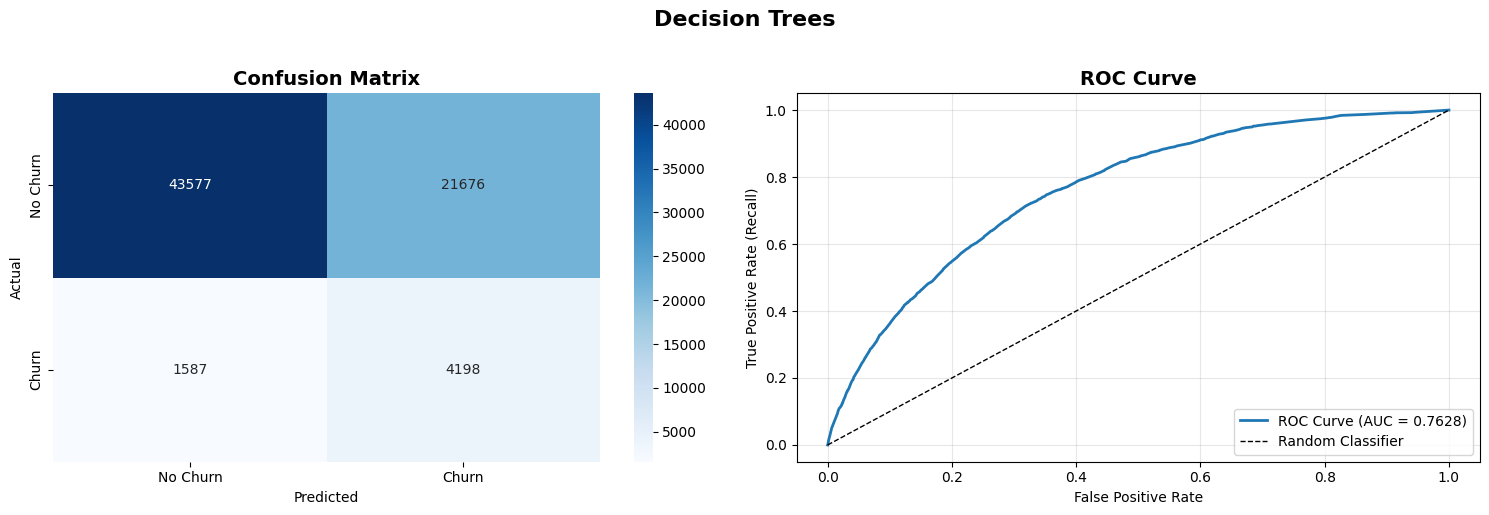

In [45]:
# Plot confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Decision Trees', fontsize=16, fontweight='bold', y=1.02)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Churn', 'Churn'])
axes[0].set_yticklabels(['No Churn', 'Churn'])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_roc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate (Recall)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()